Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

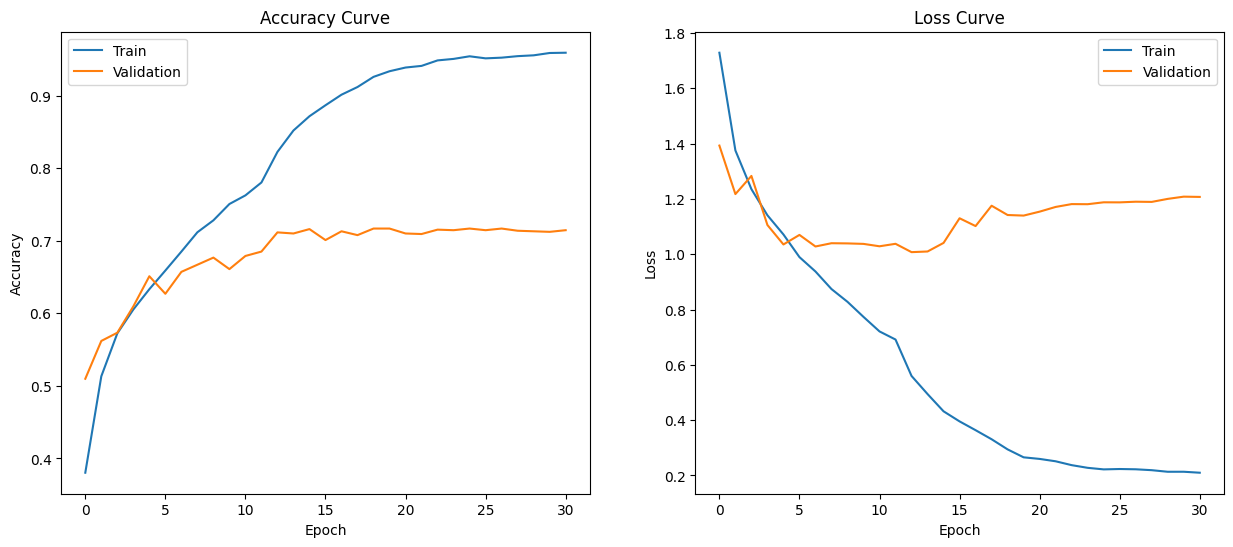

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import InceptionV3
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.applications import InceptionV3
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# 配置参数
ORIGINAL_HEIGHT = 24    # 原始图像尺寸
ORIGINAL_WIDTH = 40
TARGET_SIZE = 128       # 目标缩放尺寸
BATCH_SIZE = 32
NUM_CLASSES = 8
EPOCHS = 50             # 增加训练轮次
SEED = 42

# 数据集路径
DATASET_DIR = r'E:\CDUT\English\7 Term\Project\model\archive\8classes'

# 自动计算缩放尺寸
scale = min(TARGET_SIZE/ORIGINAL_HEIGHT, TARGET_SIZE/ORIGINAL_WIDTH)
new_h = int(ORIGINAL_HEIGHT * scale)
new_w = int(ORIGINAL_WIDTH * scale)

# 数据准备函数
def prepare_datasets(root_dir):
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(root_dir))
    
    for label_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(root_dir, class_name)
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_dir, filename))
                labels.append(label_idx)
    
    return image_paths, np.array(labels), class_names

# 改进的预处理流程
def preprocess_image(image, augment=False):
    # 高质量缩放与填充
    image = tf.image.resize(
        image, [new_h, new_w],
        method=tf.image.ResizeMethod.BICUBIC
    )
    image = tf.image.pad_to_bounding_box(
        image, 
        offset_height=(TARGET_SIZE-new_h)//2,
        offset_width=(TARGET_SIZE-new_w)//2,
        target_height=TARGET_SIZE,
        target_width=TARGET_SIZE
    )
    
    # 数据增强
    if augment:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, 0.15)
        image = tf.image.random_contrast(image, 0.9, 1.1)
    
    return image/255.0

def create_dataset(image_paths, labels, augment=False):
    def parse_function(path, label):
        image = tf.io.decode_jpeg(tf.io.read_file(path), channels=3)
        return preprocess_image(image, augment), label
    
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 优化后的模型架构
def build_optimized_model():
    # 使用动态输入尺寸
    base_model = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(TARGET_SIZE, TARGET_SIZE, 3)
    )
    
    # 精细微调策略
    for layer in base_model.layers[:150]:
        layer.trainable = False
    for layer in base_model.layers[150:]:
        if isinstance(layer, layers.BatchNormalization):
            layer.trainable = False
        else:
            layer.trainable = True

    # 动态时空特征处理
    x = base_model.output
    h, w = base_model.output.shape[1], base_model.output.shape[2]
    x = layers.Reshape((h * w, 2048))(x)
    
    # 增强的序列建模
    x = layers.LSTM(128, return_sequences=True, dropout=0.3)(x)
    x = layers.LayerNormalization()(x)
    
    # 混合注意力机制
    attn = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = layers.Concatenate()([x, attn])
    
    # 优化分类头
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu', 
                    kernel_regularizer=regularizers.l1_l2(1e-5, 1e-4))(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    return models.Model(base_model.input, outputs)

# 主流程
if __name__ == "__main__":
    # 准备数据
    image_paths, labels, class_names = prepare_datasets(DATASET_DIR)
    X_train, X_test, y_train, y_test = train_test_split(
        image_paths, labels, test_size=0.2, stratify=labels, random_state=SEED)
    
    # 创建数据集
    train_dataset = create_dataset(X_train, y_train, augment=True)
    test_dataset = create_dataset(X_test, y_test)
    
    # 构建模型
    model = build_optimized_model()
    optimizer = optimizers.Adam(
        learning_rate=1e-4,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=True
    )
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    model.summary()
    
    # 类别权重
    class_weights = class_weight.compute_class_weight(
        'balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(enumerate(class_weights))
    
    # 训练配置
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=12,
            restore_best_weights=True,
            mode='max'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6
        )
    ]
    
    # 渐进式训练
    history = model.fit(
        train_dataset,
        validation_data=test_dataset,
        epochs=EPOCHS,
        class_weight=class_weights,
        callbacks=callbacks
    )
    
    # 评估与可视化
    y_pred = np.argmax(model.predict(test_dataset), axis=1)
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Accuracy Curve')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Loss Curve')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

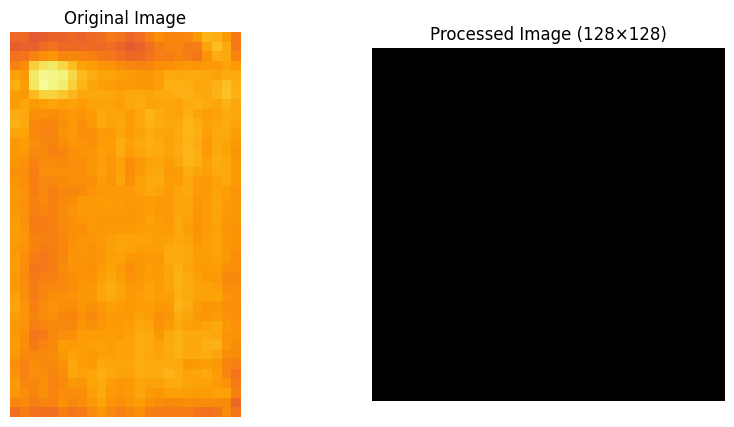

In [3]:
import matplotlib.pyplot as plt

def visualize_preprocessing(image_path):
    # 读取原始图像
    raw_image = tf.io.read_file(image_path)
    raw_image = tf.image.decode_jpeg(raw_image, channels=3)
    
    # 应用预处理
    processed_image = preprocess_image(raw_image, augment=False)
    
    # 转换为numpy数组
    raw_img_np = raw_image.numpy().astype('uint8')
    proc_img_np = processed_image.numpy().astype('uint8')
    
    # 创建对比图
    plt.figure(figsize=(10,5))
    
    # 原始图像
    plt.subplot(1,2,1)
    plt.imshow(raw_img_np)
    plt.title('Original Image')
    plt.axis('off')
    
    # 处理后图像
    plt.subplot(1,2,2)
    plt.imshow(proc_img_np)
    plt.title('Processed Image (128×128)')
    plt.axis('off')
    
    plt.show()

# 选择一个样本进行可视化（替换为你数据集中的实际路径）
sample_path = image_paths[0]  # 取第一个样本路径
visualize_preprocessing(sample_path)

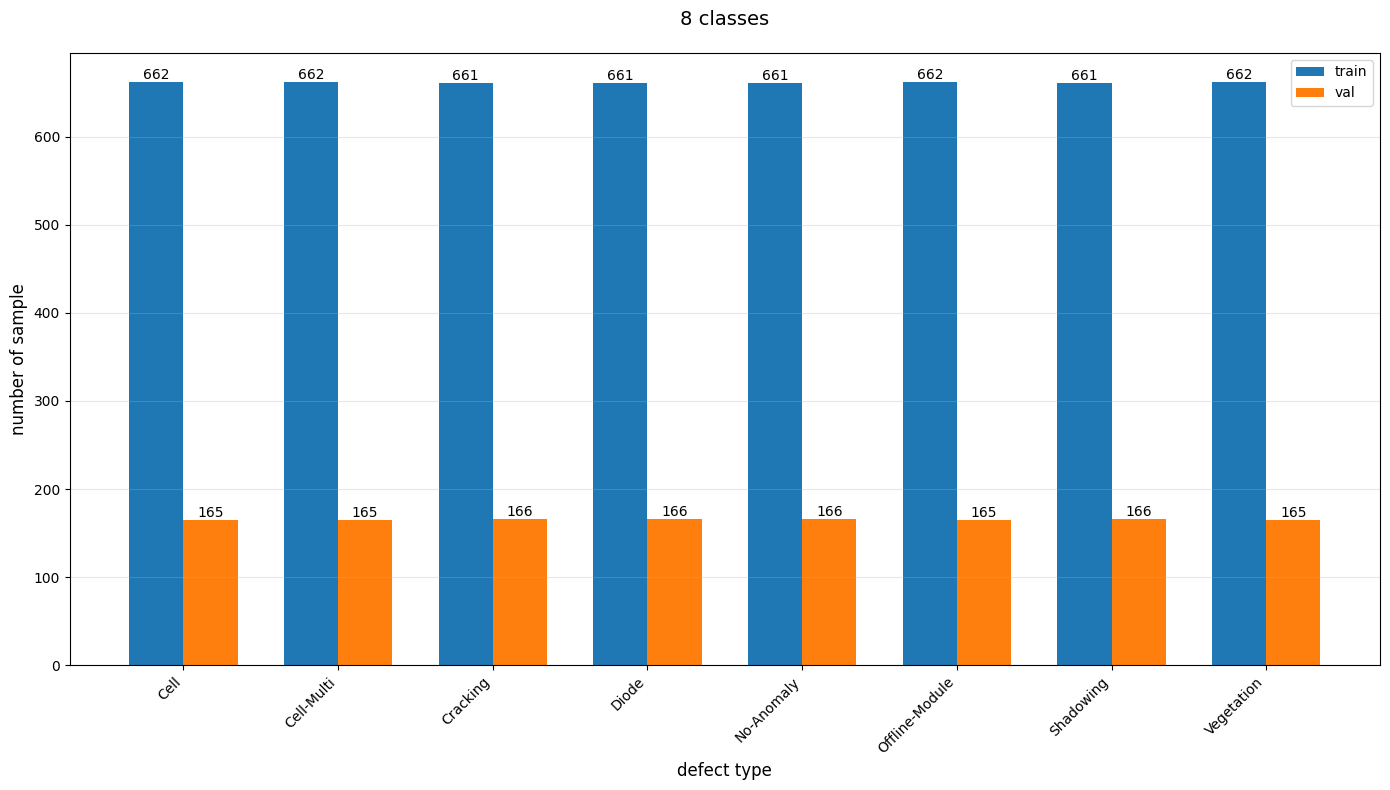

In [4]:
def plot_class_distribution(y_train, y_test, class_names):
    # 统计各类别数量
    train_counts = np.bincount(y_train, minlength=NUM_CLASSES)
    test_counts = np.bincount(y_test, minlength=NUM_CLASSES)
    
    # 创建画布
    plt.figure(figsize=(14, 8))
    
    # 设置柱状图参数
    bar_width = 0.35
    index = np.arange(NUM_CLASSES)
    
    # 颜色方案
    train_color = '#1f77b4'  # 蓝色
    test_color = '#ff7f0e'   # 橙色
    
    # 绘制柱状图
    bars_train = plt.bar(index - bar_width/2, train_counts, bar_width,
                        color=train_color, label='train')
    bars_test = plt.bar(index + bar_width/2, test_counts, bar_width,
                       color=test_color, label='val')
    
    # 添加数值标签
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                     f'{height}',
                     ha='center', va='bottom', fontsize=10)
    
    add_labels(bars_train)
    add_labels(bars_test)
    
    # 图表装饰
    plt.title(f'{NUM_CLASSES} classes', fontsize=14, pad=20)
    plt.xlabel('defect type', fontsize=12)
    plt.ylabel('number of sample', fontsize=12)
    plt.xticks(index, class_names, rotation=45, ha='right', fontsize=10)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    
    # 显示图像
    plt.show()

# 在数据准备后调用（添加到此处）
plot_class_distribution(
    y_train=y_train,  # 已从train_test_split获得
    y_test=y_test,    # 测试集标签
    class_names=class_names[:NUM_CLASSES]  # 根据NUM_CLASSES参数截取
)
# ========================================================


预测样例对比：
预测标签: [5 5 0 4 4 1 6 7 1 5]
真实标签: [5 5 0 4 4 7 6 7 1 4]


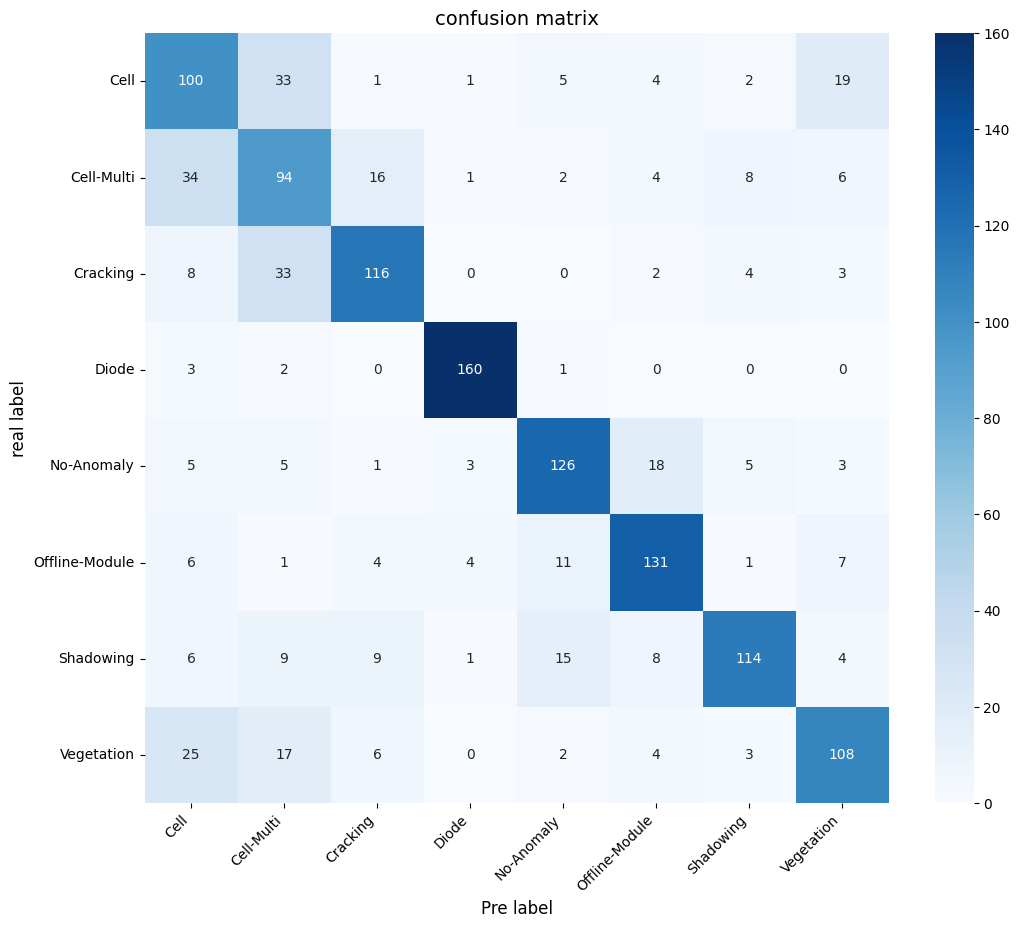

E:\Anaconda\envs\TF2\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23439 (\N{CJK UNIFIED IDEOGRAPH-5B8F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
E:\Anaconda\envs\TF2\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
E:\Anaconda\envs\TF2\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


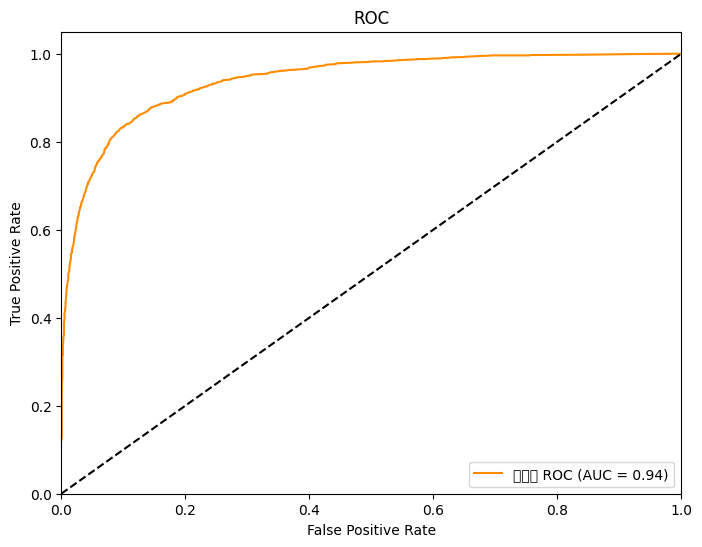


关键指标：
准确率: 0.7168
宏平均精确率: 0.7268
宏平均召回率: 0.7166
宏平均F1: 0.7197

详细分类报告：
                precision    recall  f1-score   support

          Cell       0.53      0.61      0.57       165
    Cell-Multi       0.48      0.57      0.52       165
      Cracking       0.76      0.70      0.73       166
         Diode       0.94      0.96      0.95       166
    No-Anomaly       0.78      0.76      0.77       166
Offline-Module       0.77      0.79      0.78       165
     Shadowing       0.83      0.69      0.75       166
    Vegetation       0.72      0.65      0.69       165

      accuracy                           0.72      1324
     macro avg       0.73      0.72      0.72      1324
  weighted avg       0.73      0.72      0.72      1324



In [5]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score
)
import seaborn as sns
from sklearn.preprocessing import label_binarize

# 获取测试集预测结果
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

# 获取真实标签（需从数据集提取）
y_true = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)

# 打印预测样例
print("\n预测样例对比：")
print("预测标签:", y_pred[:10])
print("真实标签:", y_true[:10])

# 多分类混淆矩阵
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel("Pre label", fontsize=12)
plt.ylabel("real label", fontsize=12)
plt.title("confusion matrix", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

# 多分类ROC曲线（OvR策略）
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=range(n_classes))

# 计算每个类别的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 计算宏平均ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

plt.figure(figsize=(8, 6))
plt.plot(all_fpr, mean_tpr, color='darkorange',
         label=f'宏平均 ROC (AUC = {auc(all_fpr, mean_tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

# 多分类评估指标
print("\n关键指标：")
print(f"准确率: {accuracy_score(y_true, y_pred):.4f}")
print(f"宏平均精确率: {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"宏平均召回率: {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"宏平均F1: {f1_score(y_true, y_pred, average='macro'):.4f}")

# 分类报告
print("\n详细分类报告：")
print(classification_report(y_true, y_pred, target_names=class_names))

In [6]:
from numba import cuda

cuda.select_device(0)
cuda.close()